In [3]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# # Install dependencies as needed:
# # pip install kagglehub[pandas-datasets]
# import kagglehub
# from kagglehub import KaggleDatasetAdapter

# # Set the path to the file you'd like to load
# file_path = ""

# # Load the latest version
# df = kagglehub.load_dataset(
#   KaggleDatasetAdapter.PANDAS,
#   "zaraks/pascal-voc-2007",
#   file_path,
#   # Provide any additional arguments like 
#   # sql_query or pandas_kwargs. See the 
#   # documenation for more information:
#   # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
# )

# print("First 5 records:", df.head())

In [5]:
# import os.path
# path = '/kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007'
# num_files = len([f for f in os.listdir(path)
#                 if os.path.isfile(os.path.join(path, f))])
# print(num_files)

In [1]:
!pip install torch torchvision pandas lxml matplotlib scikit-learn

In [2]:
import os
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Constants
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 20
VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

In [3]:
# Pad image with black pixels to match target size
def pad_image(image, target_size):
    image = img_to_array(image)  # Convert to array
    h, w, _ = image.shape
    target_h, target_w = target_size

    padded_image = np.zeros((target_h, target_w, 3), dtype=np.float32)

    scale_h = target_h / h
    scale_w = target_w / w
    scale = min(scale_h, scale_w)

    new_w = int(w * scale)
    new_h = int(h * scale)

    resized_image = Image.fromarray(image.astype('uint8')).resize((new_w, new_h), Image.LANCZOS)
    resized_image = img_to_array(resized_image) / 255.0

    y_offset = (target_h - new_h) // 2
    x_offset = (target_w - new_w) // 2
    padded_image[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_image

    return padded_image, scale, (x_offset, y_offset)

In [4]:
# Load images and corresponding annotation boxes/labels
def load_voc_data(img_dir, anno_dir):
    images = []
    annotations = []

    for img_file in os.listdir(img_dir):
        if img_file.endswith('.jpg'):
            img_path = os.path.join(img_dir, img_file)
            image = load_img(img_path)
            padded_img, scale, offset = pad_image(image, IMAGE_SIZE)
            images.append(padded_img)

            anno_file = img_file.replace('.jpg', '.xml')
            anno_path = os.path.join(anno_dir, anno_file)

            bboxes = []
            labels = []

            if os.path.exists(anno_path):
                tree = ET.parse(anno_path)
                root = tree.getroot()

                for obj in root.findall('object'):
                    label = obj.find('name').text
                    if label in VOC_CLASSES:
                        class_index = VOC_CLASSES.index(label) + 1  # Class index starts from 1
                        labels.append(class_index)

                        bndbox = obj.find('bndbox')
                        xmin = int(bndbox.find('xmin').text)
                        ymin = int(bndbox.find('ymin').text)
                        xmax = int(bndbox.find('xmax').text)
                        ymax = int(bndbox.find('ymax').text)

                        # Apply scaling and padding offset
                        xmin = int(xmin * scale + offset[0])
                        xmax = int(xmax * scale + offset[0])
                        ymin = int(ymin * scale + offset[1])
                        ymax = int(ymax * scale + offset[1])

                        bboxes.append([xmin, ymin, xmax, ymax])

            annotations.append((np.array(bboxes), np.array(labels)))

    return np.array(images), annotations

In [5]:
# Load the dataset
img_dir = '/kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages'
anno_dir = '/kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/Annotations'

images, annotations = load_voc_data(img_dir, anno_dir)

print(f"✅ Loaded {len(images)} images.")
print(f"✅ Loaded {len(annotations)} annotations.")

✅ Loaded 5011 images.
✅ Loaded 5011 annotations.


### Apply simple RCNN

In [6]:
from sklearn.model_selection import train_test_split

def prepare_labels(annotations):
    multi_labels = []
    for _, labels in annotations:
        label_vec = np.zeros(NUM_CLASSES)
        for label in labels:
            if label > 0:
                label_vec[label - 1] = 1  # shift back to 0-indexed
        multi_labels.append(label_vec)
    return np.array(multi_labels)

labels = prepare_labels(annotations)

In [7]:
from sklearn.model_selection import train_test_split

# First split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    images, labels, test_size=0.15, random_state=42)

# Then split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42)  # 0.1765 * 0.85 ≈ 0.15

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (3507, 224, 224, 3), (3507, 20)
Validation set: (752, 224, 224, 3), (752, 20)
Test set: (752, 224, 224, 3), (752, 20)


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

NUM_CLASSES = 20

# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.3),
#     Dense(NUM_CLASSES, activation='sigmoid')  # sigmoid for multi-label
# ])

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze layers

# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     Dense(256, activation='relu'),
#     Dense(NUM_CLASSES, activation='sigmoid')
# ])
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),  # Increased capacity
    Dropout(0.6),                   # Higher dropout
    BatchNormalization(),
    Dense(NUM_CLASSES, activation='sigmoid')
])

# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),  # Added layer
#     MaxPooling2D((2, 2)),                    # Added pooling
#     Flatten(),
#     Dense(256, activation='relu'),           # Increased neurons
#     Dropout(0.5),                            # Increased dropout
#     Dense(NUM_CLASSES, activation='sigmoid')
# ])

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower LR
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2):
    # Implement focal loss to focus on hard examples
    pt = tf.where(y_true == 1, y_pred, 1 - y_pred)
    return -alpha * (1 - pt)**gamma * tf.math.log(pt)


model.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy'])


model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,926,164 (11.16 MB)

 Trainable params: 667,156 (2.54 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

In [30]:
# # # Just running .fit will show you the progress by default
# # history = model.fit(
# #     X_train, y_train,
# #     epochs=50,
# #     batch_size=32,  # Reduce batch size if necessary
# #     validation_data=(X_val, y_val),
# #     verbose=1
# # )
# # callbacks = [
# #     EarlyStopping(patience=5, restore_best_weights=True),
# #     ReduceLROnPlateau(factor=0.1, patience=3)
# # ]
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10),
#     ModelCheckpoint('best_model.keras', save_best_only=True)
# ]

# history = model.fit(
#     X_train, y_train,
#     epochs=50,  # Train longer
#     batch_size=32,
#     validation_data=(X_val, y_val),
#     callbacks=callbacks,
#     verbose=1
# )

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=100,  # Increased epochs
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 305ms/step - accuracy: 0.4888 - loss: 0.0106 - val_accuracy: 0.6410 - val_loss: 0.0071 - learning_rate: 4.0000e-05
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 32s 275ms/step - accuracy: 0.4960 - loss: 0.0101 - val_accuracy: 0.6423 - val_loss: 0.0072 - learning_rate: 4.0000e-05
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 32s 275ms/step - accuracy: 0.5058 - loss: 0.0100 - val_accuracy: 0.6436 - val_loss: 0.0073 - learning_rate: 4.0000e-05
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 32s 276ms/step - accuracy: 0.4901 - loss: 0.0100 - val_accuracy: 0.6410 - val_loss: 0.0073 - learning_rate: 4.0000e-05
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 32s 276ms/step - accuracy: 0.5042 - loss: 0.0100 - val_accuracy: 0.6463 - val_loss: 0.0073 - learning_rate: 4.0000e-05
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 32s 275ms/step - accuracy: 0.5127 - loss: 0.0098 - val_accuracy: 0.6463 - val_loss: 0.0072 - learning_rate: 4.0000e-05
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━

In [31]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Example prediction
y_pred = model.predict(X_test[:5])
print("Predicted labels:", np.round(y_pred))
print("Actual labels:", y_test[:5])

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6083 - loss: 0.0076
Test Loss: 0.0073
Test Accuracy: 0.6223
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted labels: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Actual labels: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


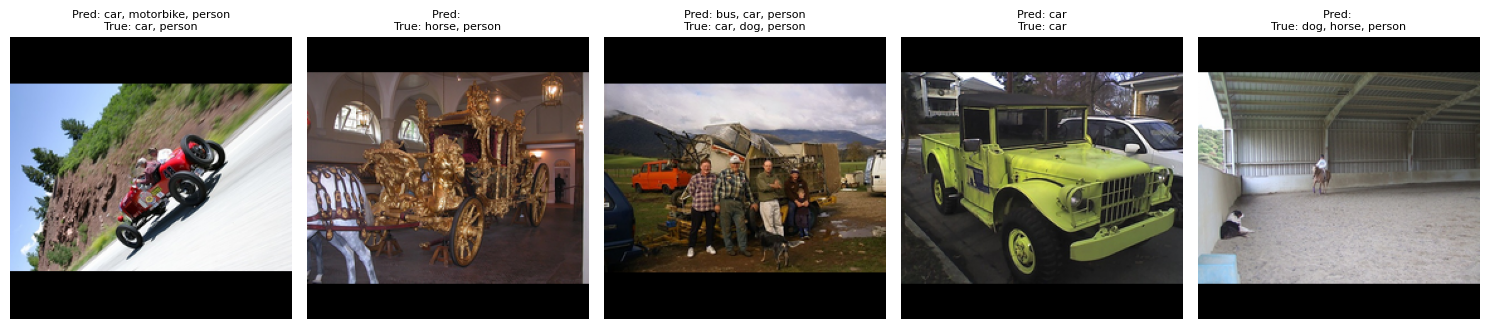

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Show predictions for the first 5 test images
num_samples = 5
preds = model.predict(X_test[:num_samples])
rounded_preds = np.round(preds)

# Function to decode class indices into class names
def decode_labels(labels):
    return [VOC_CLASSES[i] for i in range(len(labels)) if labels[i] == 1]

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_test[i])
    plt.axis('off')

    pred_labels = decode_labels(rounded_preds[i])
    true_labels = decode_labels(y_test[i])

    plt.title(f"Pred: {', '.join(pred_labels)}\nTrue: {', '.join(true_labels)}", fontsize=8)

plt.tight_layout()
plt.show()


In [33]:
model.save("pascal_voc_model.h5")


In [36]:
!pip install -q tensorflow tensorflow-hub opencv-python

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os


In [47]:
from tensorflow.keras.models import load_model
model = load_model("pascal_voc_model.h5", compile=False)


In [48]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

IMAGE_SIZE = (224, 224)

def preprocess_image(image_path):
    image = load_img(image_path, target_size=IMAGE_SIZE)
    image_array = img_to_array(image) / 255.0
    return np.expand_dims(image_array, axis=0), image

In [49]:
# Find actual path (adjust this based on your dataset structure in Kaggle)
input_tensor, original_img = preprocess_image('/kaggle/input/pascal-voc-2007/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000031.jpg')
predictions = model.predict(input_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [51]:
class_probs = model.predict(input_tensor)[0]
predicted_labels = np.round(class_probs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


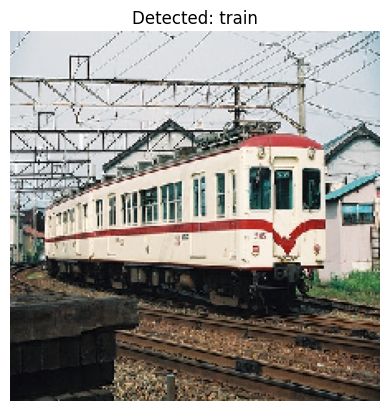

In [52]:
import matplotlib.pyplot as plt
VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

def show_image_with_labels(image, labels):
    plt.imshow(image)
    plt.axis('off')
    label_names = [VOC_CLASSES[i] for i in range(len(labels)) if labels[i] == 1]
    plt.title("Detected: " + ', '.join(label_names))
    plt.show()

show_image_with_labels(original_img, predicted_labels)

In [10]:
import xml.etree.ElementTree as ET
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to annotations and images
ANNOTATIONS_PATH = '/kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/Annotations'
IMAGES_PATH = '/kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages'

# Class list
VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

IMAGE_SIZE = (224, 224)
MAX_IMAGES = 500  # You can increase if needed

X_data, y_bbox, y_class = [], [], []

# Loop through some annotation files
for i, file in enumerate(os.listdir(ANNOTATIONS_PATH)):
    if not file.endswith(".xml") or i >= MAX_IMAGES:
        continue

    tree = ET.parse(os.path.join(ANNOTATIONS_PATH, file))
    root = tree.getroot()

    filename = root.find('filename').text
    image_path = os.path.join(IMAGES_PATH, filename)

    if not os.path.exists(image_path):
        continue

    # Load image and resize
    img = load_img(image_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img) / 255.0
    X_data.append(img_array)

    # Get image original size
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    # Get the first object (can extend to multiple later)
    obj = root.find('object')
    label = obj.find('name').text
    label_vec = np.zeros(len(VOC_CLASSES))
    if label in VOC_CLASSES:
        label_vec[VOC_CLASSES.index(label)] = 1
    y_class.append(label_vec)

    bndbox = obj.find('bndbox')
    xmin = int(bndbox.find('xmin').text) / width
    ymin = int(bndbox.find('ymin').text) / height
    xmax = int(bndbox.find('xmax').text) / width
    ymax = int(bndbox.find('ymax').text) / height
    y_bbox.append([xmin, ymin, xmax, ymax])

# Convert to arrays
X_data = np.array(X_data)
y_class = np.array(y_class)
y_bbox = np.array(y_bbox)

# Split for training and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train_class, y_val_class, y_train_bbox, y_val_bbox = train_test_split(
    X_data, y_class, y_bbox, test_size=0.2, random_state=42
)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# For validation: no augmentation
val_datagen = ImageDataGenerator()

# Apply it to your data
train_generator = train_datagen.flow(
    X_train,
    {'bbox': y_train_bbox, 'class': y_train_class},
    batch_size=32
)

val_generator = val_datagen.flow(
    X_val,
    {'bbox': y_val_bbox, 'class': y_val_class},
    batch_size=32
)


ValueError: `x` (images tensor) and `y` (labels) should have the same length. Found: x.shape = (400, 224, 224, 3), y.shape = ()

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2

NUM_CLASSES = 20

# Input
input_tensor = Input(shape=(224, 224, 3))

# Base feature extractor
base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Shared representation
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# Output branches
bbox_output = Dense(4, activation='sigmoid', name='bbox')(x)  # Normalized coordinates
class_output = Dense(NUM_CLASSES, activation='sigmoid', name='class')(x)

# Model
model = Model(inputs=input_tensor, outputs=[bbox_output, class_output])

# Compile with multiple losses
model.compile(
    optimizer='adam',
    loss={
        'bbox': 'mse',  # Mean Squared Error for bbox regression
        'class': 'binary_crossentropy'  # Multi-label classification
    },
    metrics={'class': 'accuracy'}
    
)

model.summary()


<ipython-input-15-894786eb6225>:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,592,088 (9.89 MB)

 Trainable params: 2,557,976 (9.76 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
history = model.fit(
    X_train, {'bbox': y_train_bbox, 'class': y_train_class},
    validation_data=(X_val, {'bbox': y_val_bbox, 'class': y_val_class}),
    epochs=30,
    batch_size=8,
    verbose=1
)